## Experiment 1.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn



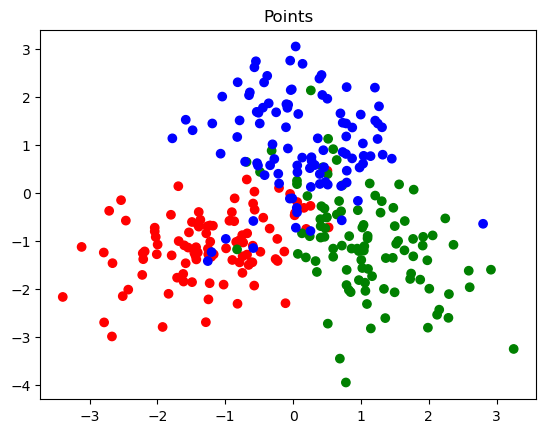

In [335]:
np.random.seed(1)
sigma_values = [0.5, 1, 2, 4, 8]
phi = np.array([1/3] * 3).reshape(3)
initial_centroids = np.array([[0, 2], [-1, 0], [1, 0]])

losses = []
accuracies = []

map_points = {0: 'r', 1: 'g', 2: 'b'}

# Plotting points
plt.title("Points")
_, _, _, data = generate_data(0.5)
plt.scatter(data[:, 0], data[:, 1], c=[map_points[i] for i in labels])

plt.show()


In [9]:
def generate_data(sigma):
    # Parameters for Gaussian distributions
    means = {
        'a': np.array([-1, -1]),
        'b': np.array([1, -1]),
        'c': np.array([0, 1])
    }

    covariances = {
        'a': sigma * np.array([2, 0.5, 0.5, 1]).reshape((2, 2)),
        'b': sigma * np.array([1, -0.5, -0.5, 2]).reshape((2, 2)),
        'c': sigma * np.array([1, 0, 0, 2]).reshape((2, 2))
    }

    # Generate data for each Gaussian distribution
    data_a = np.random.multivariate_normal(mean=means['a'], cov=covariances['a'], size=100)
    data_b = np.random.multivariate_normal(mean=means['b'], cov=covariances['b'], size=100)
    data_c = np.random.multivariate_normal(mean=means['c'], cov=covariances['c'], size=100)

    # Concatenate the data
    X = np.concatenate([data_a, data_b, data_c])

    return data_a, data_b, data_c, X


In [320]:
#kmeans
def get_assignments(data, centroids):
    assignments = []
    for point in data:
        distances = [np.linalg.norm(point - centroid) for centroid in centroids]
        assignments.append(np.argmin(distances))
    return assignments

def update_centers(data, assignments):
    n = np.zeros(6).reshape((3, 2))
    d = np.zeros(3)
    for i in range(len(assignments)):
        n[assignments[i]] += data[i]
        d[assignments[i]] += 1
    c1 = n[0] / d[0]
    c2 = n[1] / d[1]
    c3 = n[2] / d[2]
    return c1, c2, c3

def k_loss(data, assignments, centroids):
    c = centroids
    l = 0
    for i in range(len(assignments)):
        l += np.linalg.norm(data[i] - c[assignments[i]])
    return l / len(assignments)
        
def k_means(data, centroids):
    a = get_assignments(data, centroids)
    loss = k_loss(data, a, centroids)
    n1, n2, n3 = update_centers(data, a)
    if loss - k_loss(data, a, [n1, n2, n3]) != 0:
        return k_means(data, [n1, n2, n3])
    else:
        return centroids, loss
    
def get_accuracy(clusters, assign):
    confusion_matrix = np.zeros((3, 3))

    n = len(assign)
    for it in range(n):
        true_label = assign[it]
        predicted_label = clusters[it]
        confusion_matrix[true_label, predicted_label] += 1

    diagonal_sum = np.sum(np.diag(confusion_matrix))

    accuracy1 = diagonal_sum / n
    accuracy2 = np.sum(np.diag(np.roll(confusion_matrix, 1, axis=1))) / n
    accuracy3 = np.sum(np.diag(np.roll(confusion_matrix, 2, axis=1))) / n

    return max(accuracy1, accuracy2, accuracy3)


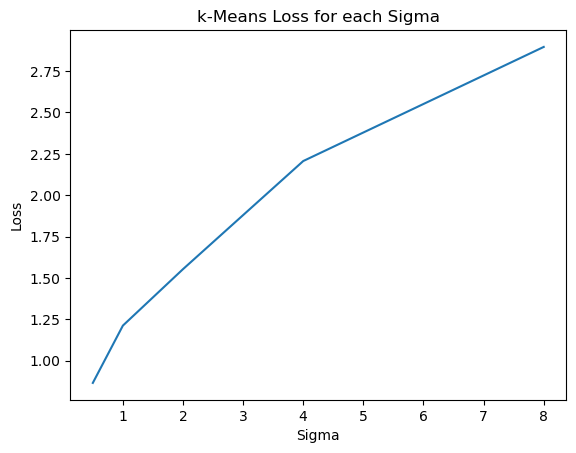

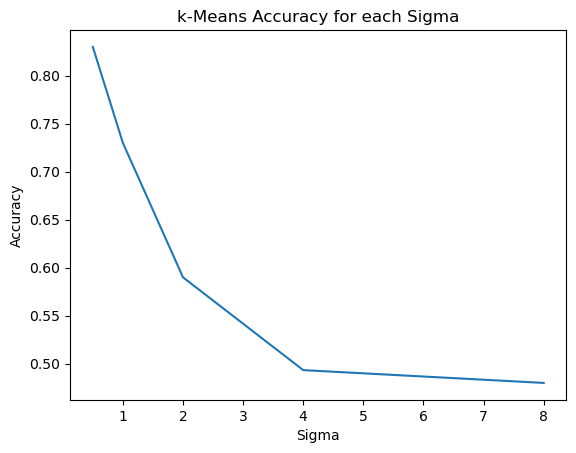

<Figure size 640x480 with 0 Axes>

In [321]:
for sigma in sigma_values:
    a, b, c, X = generate_data(sigma)
    data = np.concatenate([a, b, c])
    
    new_centroids, loss = k_means(data, initial_centroids)
    losses.append(loss)
    
    assignments = get_assignments(data, new_centroids)
    accuracy = get_accuracy(clusters, assignments)
    accuracies.append(accuracy)

# Plotting
plt.plot(sigma_values, losses)
plt.ylabel("Loss")
plt.xlabel("Sigma")
plt.title("k-Means Loss for each Sigma")
plt.savefig("images/kmeans_loss.png")
plt.show()
plt.clf()

plt.plot(sigma_values, accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Sigma")
plt.title("k-Means Accuracy for each Sigma")
plt.savefig("images/kmeans_accuracy.png")
plt.show()
plt.clf()

In [322]:
#gmm
def initialize_params(sigma):

    mean_error_mean = np.zeros(2)
    mean_error_cov = np.array([1, 0, 0, 1]).reshape((2, 2))
    cov_error_mean = np.zeros(4)
    cov_error_cov = np.array([0.1] * 16).reshape((4, 4))

    means = [
        np.array([-1, -1]),
        np.array([1, -1]),
        np.array([0, 1])
    ]

    covariances = [
        sigma * np.array([2, 0.5, 0.5, 1]).reshape((2, 2)),
        sigma * np.array([1, -0.5, -0.5, 2]).reshape((2, 2)),
        sigma * np.array([1, 0, 0, 2]).reshape((2, 2))
    ]

    means = [mean + np.random.multivariate_normal(mean=mean_error_mean, cov=mean_error_cov) for mean in means]

    return means, covariances


def get_expectations(data, phi, mu, sig):
    n = len(data)
    p = len(phi)
    w = np.zeros(n * p).reshape((n, p))
    for i in range(n):
        d = 0
        for j in range(p):
            d += mvn.pdf(x=data[i], mean=mu[j], cov=sig[j]) * phi[j]
        for j in range(p):
            pz = phi[j]
            px = mvn.pdf(x=data[i], mean=mu[j], cov=sig[j])
            w[i, j] = (px * pz) / d
    return w

def maximize_params(data, weights):
    n = len(data)
    p = len(weights[0])
    phi = sum(weights) / n
    mu = (data.T.dot(weights) / sum(weights)).T
    d = phi * n
    sig = []
    for j in range(p):
        s = np.zeros(4).reshape((2,2))
        for i in range(n):
            w = weights[i, j]
            v = data[i] - mu[j]
            s += w * np.outer(v, v)
        sig.append(s / d[j])
    return phi, mu, sig

def get_labels(weights):
    l = []
    for i in range(len(weights)):
        l.append(weights[i].argmax())
    return(l)

def get_loss(weights, labels):
    l = 0
    for i in range(len(labels)):
        l += np.log(weights[i][labels[i]])
    return -l 

def get_accuracy(source, labels):
    confusion_matrix = np.zeros((3, 3))

    for true_label, predicted_label in zip(source, labels):
        confusion_matrix[true_label, predicted_label] += 1

    diagonal_sum = np.sum(np.diag(confusion_matrix))
    total_elements = np.sum(confusion_matrix)

    accuracy1 = diagonal_sum / total_elements
    accuracy2 = np.sum(np.diag(np.roll(confusion_matrix, 1, axis=1))) / total_elements
    accuracy3 = np.sum(np.diag(np.roll(confusion_matrix, 2, axis=1))) / total_elements

    return max(accuracy1, accuracy2, accuracy3)


def gmm(data, phi, mu, sig, epsilon):
    while True:
        weights = get_expectations(data, phi, mu, sig)
        labels = get_labels(weights)
        current_loss = get_loss(weights, labels)

        phi, mu, sig = maximize_params(data, weights)

        new_weights = get_expectations(data, phi, mu, sig)
        new_labels = get_labels(new_weights)
        new_loss = get_loss(new_weights, new_labels)

        if abs(current_loss - new_loss) <= epsilon:
            return phi, mu, sig, new_loss


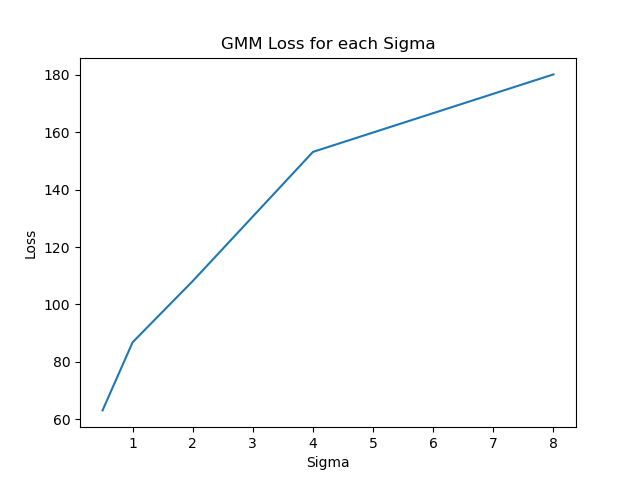

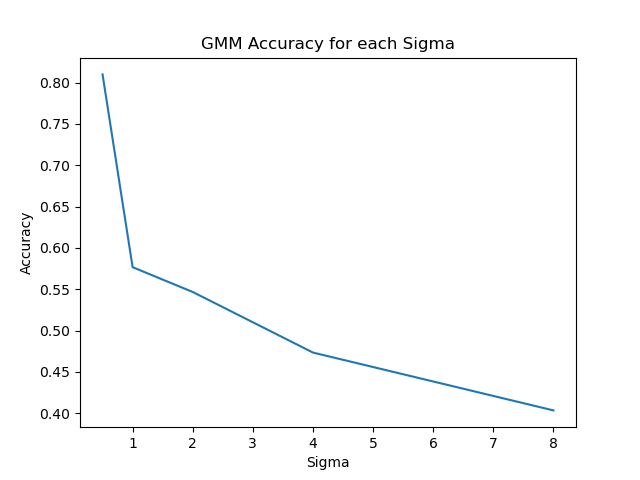

In [341]:
losses = []
accuracies = []
sigma_values = [0.5, 1, 2, 4, 8]
phi = np.array([1/3] * 3).reshape(3)
initial_centroids = np.array([[0, 2], [-1, 0], [1, 0]])

for sigma in sigma_values:
    a, b, c, X = generate_data(sigma)
    data = np.concatenate([a, b, c])

    mu, sig = initialize_params(sigma)
    phi, mu, sig, l = gmm(data, phi, mu, sig, epsilon=0.1)

    losses.append(l)

    # Get labels from GMM
    gmm_labels = get_labels(get_expectations(data, phi, mu, sig))
    accuracy = get_accuracy(source, gmm_labels)
    accuracies.append(accuracy)

# Plotting
plt.plot(sigma_values, losses)
plt.ylabel("Loss")
plt.xlabel("Sigma")
plt.title("GMM Loss for each Sigma")
plt.savefig("images/gmm_loss.png")
plt.show()
plt.clf()

plt.plot(sigma_values, accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Sigma")
plt.title("GMM Accuracy for each Sigma")
plt.savefig("images/gmm_accuracy.png")
plt.show()
plt.clf()

## Experiment 2.3

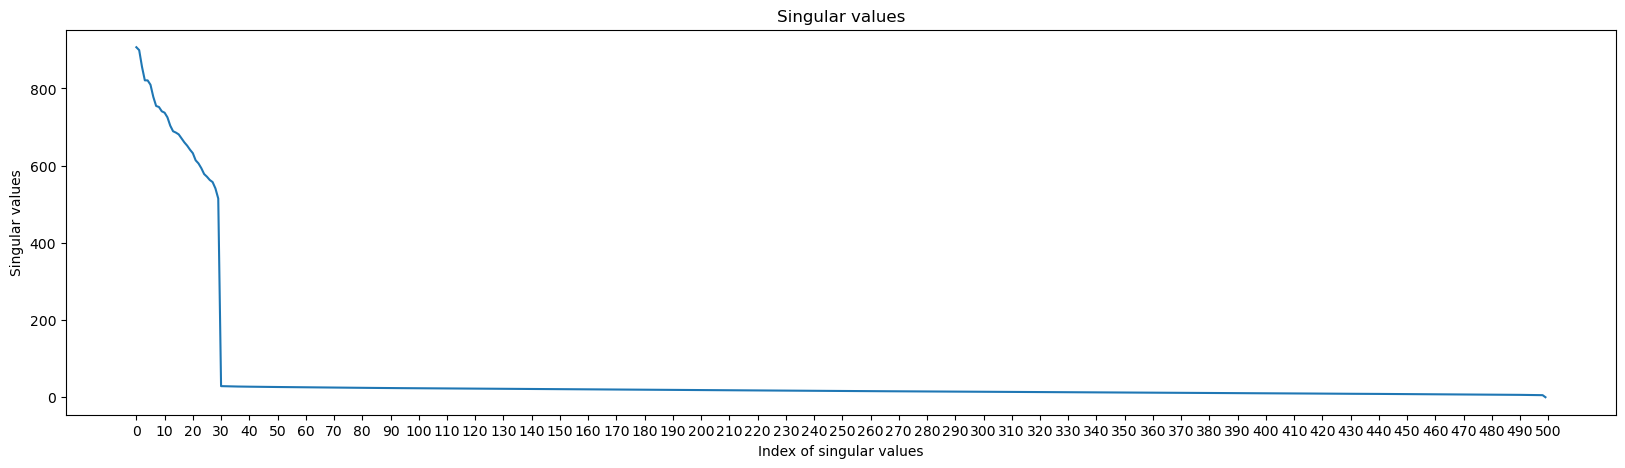

In [158]:
import numpy as np
import pandas as pd
import numpy.linalg as la
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from numpy.testing import assert_array_almost_equal
import matplotlib.pyplot as plt


np.set_printoptions(precision=3)

D2 = pd.read_csv('data/data2D.csv', header=None, index_col=None)
D1000 = pd.read_csv('data/data1000D.csv', header=None, index_col=None)

_, S, _ = np.linalg.svd((D1000 - D1000.mean()))
plt.figure(figsize=(20,5))

plt.xticks(np.arange(0, len(S)+1, 10))
plt.xlabel('Index of singular values')
plt.ylabel('Singular values')
plt.title('Singular values')
plt.plot(S)
plt.show()

In [353]:
def BuggyPCA(data,d):
    
    mean = np.zeros(data.shape[1])
    std = np.ones(data.shape[1])
    title = 'Buggy PCA'
    k = d
    u, s, vt = np.linalg.svd((data - mean) / std)
    components = vt[:k]
    
    datamean=data-mean
    data_pca = ((datamean) / std).dot(components.T)
    data_projected = (data_pca.dot(components)* std) + mean
    reconstruction_error = np.sum((data - data_projected) ** 2, axis=1).mean()
    return title,reconstruction_error,data_projected

def DemeanedPCA(data,d):
    
    mean = data.mean(axis=0)
    std = std = np.ones(data.shape[1])
    title = 'Demeaned PCA'
    k = d
    u, s, vt = np.linalg.svd((data - mean) / std)
    components = vt[:k]
    
    datamean=data-mean
    data_pca = ((datamean) / std).dot(components.T)
    data_projected = (data_pca.dot(components)* std) + mean
    reconstruction_error = np.sum((data - data_projected) ** 2, axis=1).mean()
    return title,reconstruction_error,data_projected

def NormalizedPCA(data,d):
    
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    title = 'Normalized PCA'
    k = d
    u, s, vt = np.linalg.svd((data - mean) / std)
    components = vt[:k]
    
    datamean=data-mean
    data_pca = ((datamean) / std).dot(components.T)
    data_projected = (data_pca.dot(components)* std) + mean
    reconstruction_error = np.sum((data - data_projected) ** 2, axis=1).mean()
    return title,reconstruction_error,data_projected

def DRO(data,d):
    data = data.to_numpy()
    components =[0, 0 ,0]
    n=data.shape[0]
    datamean= data.mean(axis=0)
    U, S, VT = np.linalg.svd((data - datamean))
    S = np.diag(S)
    k=d
    components[0] = U[:,:k]
    components[2] = VT[:k]
    components[1] = S[:k,:k]
    Z = np.sqrt(n)*components[0]
    A = ((1/np.sqrt(n))*(components[1] @ components[2])).T
    data_projected = (Z @ A.T) + datamean
    reconstruction_error = np.sum((data - data_projected) ** 2, axis=1).mean()
    title='DRO'
    return title,reconstruction_error,data_projected


def PCA(data, d=1, PCAtype=0,plot=True):
    if(PCAtype == 0):
        print("\nResults for Buggy PCA\n")
        title,reconstruction_error,data_projected=BuggyPCA(data,d)
    elif(PCAtype == 1):
        print("\nResults for Demeaned PCA\n")
        title,reconstruction_error,data_projected=DemeanedPCA(data,d)
    elif(PCAtype == 2):
        print("\nResults for Normalized PCA\n")
        title,reconstruction_error,data_projected=NormalizedPCA(data,d)
    elif(PCAtype == 3):
        print("\nResults for DRO\n")
        title,reconstruction_error,data_projected=DRO(data,d)
    
    print("Reconstruction Error : ", reconstruction_error)
    if (plot):
        plt.figure(figsize = (4,4))
        plt.scatter(data[0].to_numpy(), data[1].to_numpy(), marker='*' )
        if(PCAtype==3):
            plt.scatter(data_projected[:,0], data_projected[:,1], marker='*' )
        else:    
            plt.scatter(data_projected[0].to_numpy(), data_projected[1].to_numpy(), marker='*' )
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.xlim([0,10])
        plt.ylim([0,10])
        plt.title(title)
        plt.savefig('images/pca_{}.jpg'.format(title.replace(' ', '_')))


Results for Buggy PCA

Reconstruction Error :  0.8869030837347941

Results for Demeaned PCA

Reconstruction Error :  0.010006085628512917

Results for Normalized PCA

Reconstruction Error :  0.04947208345477067

Results for DRO

Reconstruction Error :  0.010006085628512927


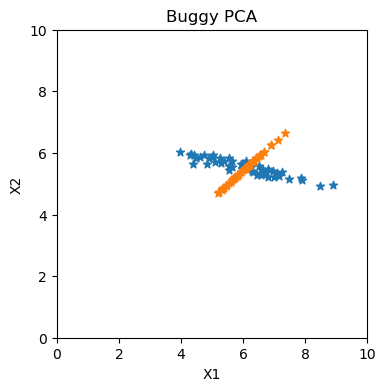

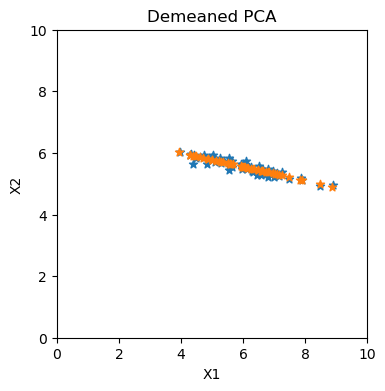

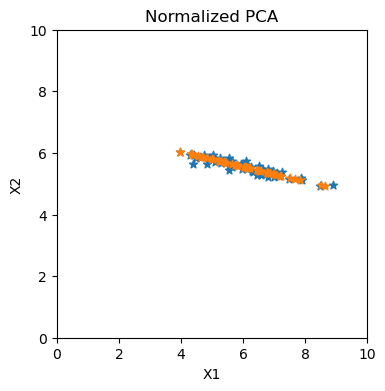

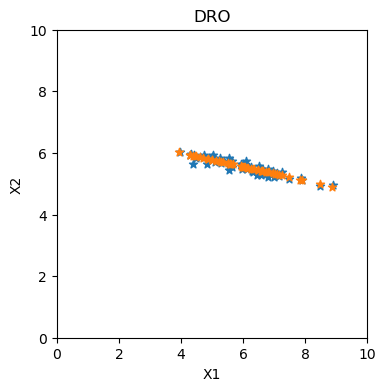

In [354]:
for i in range(4):
    PCA(D2, d=1, PCAtype=i, plot=True)

In [289]:
print('\nerror at d=30 is ')
title, reconstruction_error,data_projected = BuggyPCA(D1000,30)
print(reconstruction_error)


error at d=30 is 
802.7313986203584


In [290]:
print('\nerror at d=30 is ')
title, reconstruction_error,data_projected = DemeanedPCA(D1000,30)
print(reconstruction_error)



error at d=30 is 
273.0459589786028


In [291]:

print('\nerror at d=30 is ')
title, reconstruction_error,data_projected = NormalizedPCA(D1000,30)
print(reconstruction_error)



error at d=30 is 
273.62858099762326


In [293]:
print('\nerror at d=30 is ')
title,reconstruction_error,data_projected = DRO(D1000,30)
print(reconstruction_error)


error at d=30 is 
273.0459589786028
